# NE551 Homework 4 Addendum #
J.R. Powers-Luhn  
2016/09/28

## Problem 2 (Anderson 4.2) ##

In [255]:
%%javascript
MathJax.Extension["TeX/cancel"]={version:"2.4.0",ALLOWED:{color:1,mathcolor:1,background:1,mathbackground:1,padding:1,thickness:1}};MathJax.Hub.Register.StartupHook("TeX Jax Ready",function(){var c=MathJax.InputJax.TeX,a=MathJax.ElementJax.mml,b=MathJax.Extension["TeX/cancel"];b.setAttributes=function(h,e){if(e!==""){e=e.replace(/ /g,"").split(/,/);for(var g=0,d=e.length;g<d;g++){var f=e[g].split(/[:=]/);if(b.ALLOWED[f[0]]){if(f[1]==="true"){f[1]=true}if(f[1]==="false"){f[1]=false}h[f[0]]=f[1]}}}return h};c.Definitions.Add({macros:{cancel:["Cancel",a.NOTATION.UPDIAGONALSTRIKE],bcancel:["Cancel",a.NOTATION.DOWNDIAGONALSTRIKE],xcancel:["Cancel",a.NOTATION.UPDIAGONALSTRIKE+" "+a.NOTATION.DOWNDIAGONALSTRIKE],cancelto:"CancelTo"}},null,true);c.Parse.Augment({Cancel:function(e,g){var d=this.GetBrackets(e,""),f=this.ParseArg(e);var h=b.setAttributes({notation:g},d);this.Push(a.menclose(f).With(h))},CancelTo:function(e,g){var i=this.ParseArg(e),d=this.GetBrackets(e,""),f=this.ParseArg(e);var h=b.setAttributes({notation:a.NOTATION.UPDIAGONALSTRIKE+" "+a.NOTATION.UPDIAGONALARROW},d);i=a.mpadded(i).With({depth:"-.1em",height:"+.1em",voffset:".1em"});this.Push(a.msup(a.menclose(f).With(h),i))}});MathJax.Hub.Startup.signal.Post("TeX cancel Ready")});MathJax.Ajax.loadComplete("[MathJax]/extensions/TeX/cancel.js");

<IPython.core.display.Javascript object>

\begin{equation}
    R = \frac{M \cancel{c^2} I^2}{32 z^2 \pi r_0^2 \left( m_e \cancel{c^2} \right)^3 N_A \left(Z / M_m \right) \rho} \left[\operatorname{Ei}\left(\ln u_0 \right) - \cancel{\operatorname{Ei}\left(\ln u_1 \right)} \right] + \cancel{R_1\left(T_1\right)}
\end{equation}
and
\begin{equation}
    u = \left( \frac{4 m_e c^2 \tau}{I} \right)^2 = \left( \frac{4 m_e \cancel{c^2} T}{I M \cancel{c^2}} \right)^2
\end{equation}

In [256]:
import scipy.constants as const
from scipy.special import expi # Exponential integral function, Ei
from math import log, pi
import numpy as np
from scipy.interpolate import interp1d

In [257]:
# Constants!
I = 82 * 10 ** -6 # MeV
M = const.physical_constants['alpha particle mass energy equivalent in MeV'][0] # 3727.379... MeV
z = 2 # incident alpha particle
m_e = const.physical_constants['electron mass energy equivalent in MeV'][0]
r_0 = const.physical_constants['classical electron radius'][0] * 100 # cm
N_A = const.physical_constants['Avogadro constant'][0]
Z = 14
M_m = 28.014 # g/mol
rho = 0.00125 # g/cm^3

In [258]:
def u(T):
    numerator = 4 * m_e * T
    denominator = I * M
    return (numerator / denominator) ** 2

In [259]:
u(5)

1118.0599713539173

In [260]:
# Approximation of Exponential integral
u(5) / log(u(5))

159.28254390194414

In [261]:
def R(T, approxEi=False):
    """ Gives predicted range
        Can optionally specify approxEi to use the log approximation for Ei(log(u))
    """
    numerator = M * I * I
    denominator = 32 * z ** 2 * pi * r_0 ** 2 * m_e ** 3 * N_A * Z * rho / M_m
    if not(approxEi):
        ei = expi(log(u(T)))
    else:
        ei = u(T) / log(u(T)) # Approximation as u >> 1
    return numerator * ei / denominator

In [262]:
print R(5, approxEi=True)

2.49058984845


In [263]:
print R(5, approxEi=False)

3.04222192314


## Problem 4 ##

In [279]:
r_e = r_0 # Copying code from scratch sheet
I_water = 75.0
I_air = 85.7
rho_water = 1.0
rho_air = 0.0012

In [280]:
def beta_squared(T, m):
    """ Gives value of beta^2 for a given Mass (MeV/c^2) and Kinetic Energy (MeV)
    """
    numerator = T * (T + 2 * m)
    denominator = (T + m) ** 2
    return np.divide(numerator, denominator)

In [281]:
def gamma_squared(T, m):
    """ Gives value of gamma^2 for a given mass (MeV/c^2) and Kinetic Energy (MeV)
    """
    return 1.0 / (1 - beta_squared(T, m)) ** 0.5

In [282]:
def S_c(incident, target, T, M_b, density, I):
    """ Returns the stopping power in MeV/cm
        T in MeV
        density in g/cm^3
        Output in MeV/cm
    """
    # Currently the incident is specified in Z number. Incident is assumed to be fully ionized
    z = incident
    
    # Z is actually Z/A
    Z = target

    first = 4 * (z ** 2) * pi * (r_e ** 2) * m_e
    second = N_A * Z * density
    third = 1.0 / beta_squared(T, M_b)
    logpart = (2 * m_e * beta_squared(T, M_b) * gamma_squared(T, M_b)) / (I * 10 ** -6)
    fourth = np.log(logpart) - beta_squared(T, M_b) + beta_squared(T, M_b)

    result = first * second * third * fourth
    
    return result

In [283]:
S_c_chamber_one = S_c(1.0, 0.55, 250.0, 937.0, rho_air, I_air)

In [284]:
T_array = np.linspace(-10.0, 300.0, 260000)

In [285]:
interpolator = interp1d(
    T_array, 
    np.piecewise(
        T_array,
        [T_array <= 0.001, T_array > 0],
        [
            lambda T_array: 0.0,
            lambda T_array: S_c(1.0, 0.55, T_array, 937.0, rho_water, I_water)
        ]
    )
)

In [286]:
S_c(1.0, 0.55, 250.0, 937.0, 1.0, 75.0)

3.934864903456555

In [287]:
interpolator(250)

array(3.9348649034678584)

In [311]:
def EofT(E0, t, step=1):
    if t<step:
        return E0
    else:
        e = EofT(E0, t-step, step=step)
        if e > E0:
            return E0
        elif e>=0:
            temp = e - step * interpolator(e)
            if temp >= 0.0:
                return temp
            else:
                return 0.0

In [346]:
def bragg_curve(t, debug=False):
    S_c_chamber_one = S_c(1.0, 0.49918972273707857, 250.0, 937.0, rho_air, I_air)
    E_after_chamber = EofT(250.0, t)
    if E_after_chamber > 0.0:
        S_c_chamber_two = S_c(1.0, 0.49918972273707857, E_after_chamber, 937.0, rho_air, I_air)
    else:
        S_c_chamber_two = 0.0
    if debug is True:
        print S_c_chamber_two
        print S_c_chamber_one
        print E_after_chamber
    return S_c_chamber_two / S_c_chamber_one

In [347]:
thickness = [0.0, 10.0, 20.0, 30.0, 35.0, 36.0, 37.0, 38.0]

In [348]:
%matplotlib inline

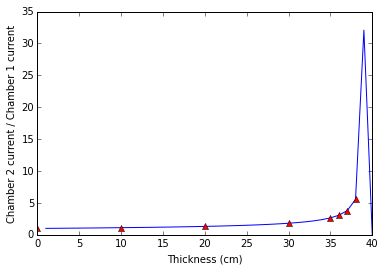

In [349]:
import matplotlib.pyplot as plt

plt.plot([i + 1.0 for i in range(40)], [bragg_curve(i + 1.0) for i in range(40)], 'b',
         thickness, [bragg_curve(i) for i in thickness], 'r^'
        )
plt.xlabel("Thickness (cm)")
plt.ylabel("Chamber 2 current / Chamber 1 current")
plt.show()